# Ipynb to 

graph and try out different 

ML concepts with a sample datasize.


A partir de las 3 tablas ya procesdas : 
* homeantennas
* sumlinks
* groundtruth

armames un datset para explorar conceptos de ML

In [1]:
## seteamos los parametros del notebook
%autosave 180
import pandas as pd; 
import os;
import random;
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np; import os;import random;
# import graphlab as gl
from IPython.display import display # para pretty-print con estetica ipython si es que estamos dentro de  un loop, if, etc
#esto es para dibujar directo a la notebook
# gl.canvas.set_target('ipynb')

# for nice graphics and plots
import seaborn as sns
palette = sns.color_palette()

# for nice long graphic titles
from textwrap import wrap

#seteamos el lugar de trabajo
HOMEDIR=os.path.expanduser('~')

PROJECTDIR = os.getcwd().split(os.sep)
PROJECTDIR =  os.sep.join(PROJECTDIR[:PROJECTDIR.index('mexico-scripts-ver2') + 1])

DATADIR = os.path.join(PROJECTDIR,'datasets')

DATADIR2 = os.path.join(PROJECTDIR,'data')
# os.chdir(DATADIR)


Autosaving every 180 seconds


In [2]:
!ls $DATADIR

data_balanced_sample.csv  gtruth_0215_0715  sl	       tree.dot
gtruth_0114_0715	  homeant	    sl.csv.gz


In [3]:
graphlab_frame = False
# graphlab_frame = 'juan' in HOMEDIR

def get_input_sframe(ds,graphlab_frame=graphlab_frame):
    if graphlab_frame:
        if ds == 'home_antenna': url = DATADIR +"/homeant"
        elif ds == 'sum_links': url  = DATADIR +"/sl"
        elif ds == 'gtruth_02': url  = DATADIR +"/gtruth_0215_0715" # can be near ground truth (previous to july 2015)
        elif ds == 'gtruth_01': url  =  DATADIR +"/gtruth_0114_0715" # or can be old GT
        else: print('type chosen is %s, type should be home_antenna, sum_links, gtruth_02 or gtruth_01' % ds)
    else:
        url = DATADIR + '/data_balanced_sample.csv'
    return url 

In [4]:
#from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
#NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler, SMOTE,\
#SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

## decide if load a reduced size dataset

In [5]:
# set what is the resulting sample we want of the global dataset
global_split = 0.25
global_split = None

# since we have 2 datets that will be later joined and which are going to be previously sampled, in the end this 
# independent sampling will result in that, after the join, the dataset will have a size of fraction given by 
# the `global_split` variable
if global_split:
    
    seed = 2015
    sample = pd.np.sqrt(global_split)
    print(sample)

In [6]:
%%time

if graphlab_frame:
    sf_table, _ = gl.load_sframe(get_input_sframe('home_antenna',graphlab_frame))
    sl_table, _ = gl.load_sframe(get_input_sframe('sum_links',graphlab_frame))
    # no need to sample the gt table since it is very small in memory
    gt_table = gl.load_sframe(get_input_sframe('gtruth_01',graphlab_frame))

    if global_split:

        sf_table, _ = sf_table.random_split(sample,seed=seed)
        sl_table, _ = sl_table.random_split(sample,seed=seed)


    rename_gt = (dict([(col,col+"_gt") for col in gt_table.column_names() if col != 'USER']))

    #agrego la etiqueta "_gt" a las columnas del ground_truth
    gt_table.rename(rename_gt) 
else:
    data = pd.read_csv(get_input_sframe('sum_links',graphlab_frame))

CPU times: user 3.81 s, sys: 256 ms, total: 4.06 s
Wall time: 4.63 s


In [7]:
if graphlab_frame:
    print(sf_table.shape, sl_table.shape, gt_table.shape)
else:
    print(data.shape)

(153010, 176)


## simple format description

Aca miramos las top 10 antenas que utilizo un usuario, ordeandas de 0 a 10 segun el uso, en numero de llamados, que el user le daba a c. antenna. _0_ Seria la antenna mas utilizada y _10_ la menos utilizada. El count es la cantidad de veces que utilizo esa antenna. 

Cuando aparece _WEEKNIGHT_ en el nombre de la columna, es porque cumple la condicion de que los llamados fueron hechos de noche fuera del horario [8,20] y dentro de la semana laboral.

Siguiendo las definiciones del trabajo de Caro, un user es _EPIDEMIC_ siii su ANTENNA_WEEKNIGHT_0 (esta es la home_antenna) pertence a la zona epidemica.

El mobility_diameter es el radio de las antennas (0 si uso una sola, etc.) utilizadas por este user. Nuevamente el modificador _WEEKNIGHT_ solo aplica para antennas utilizadas en esos horarios.

In [8]:
# column names
if graphlab_frame:
    print(sf_table.column_names())
else:
    print(data.columns)

Index([u'USER', u'COUNT_0', u'COUNT_1', u'COUNT_2', u'COUNT_3', u'COUNT_4',
       u'COUNT_5', u'COUNT_6', u'COUNT_7', u'COUNT_8',
       ...
       u'TimeWeekDay_IN_11', u'CallsWeekEnd_IN_11', u'TimeWeekNight_IN_11',
       u'TimeWeekEnd_IN_VUL_11', u'CallsWeekDay_IN_VUL_11',
       u'CallsWeekNight_IN_VUL_11', u'TimeWeekDay_IN_VUL_11',
       u'CallsWeekEnd_IN_VUL_11', u'TimeWeekNight_IN_VUL_11',
       u'VULNERABLE_IN_11'],
      dtype='object', length=176)


## sum links description

La tabla sum_links tiene mas atributos y con data mas rica en informacion:
    
Esencialmente para c/ user miramos la cantidad de llamados y el tiempo que duraron esos llamados pero segmentando con distintos modificadores. `Time` representa la duracion del llamado y Calls el conteo de llamados.

Los modficadores/ segmentaciones son:

* mes en el cual estamos parados (12 == diciembre, ..., 08 == agosto)
* OUT/IN, separa por la direccion de los llamados si salientes u entrantes.
* _VULN_ : separa los llamados que fueron realizados hacia/desde un target_user (en una llamada hay 2 usuarios, el origin o el target) viviendo en una zona epidemica. Donde la home antena de un target_user determina su vulnerabilidad segun si es zona epidemica o no.
* Weekend, WeekDay y WeekNight son lo que suenan. Weekend el finde, Weeknight la semana pero fuera de horario laboral y Weekday en horario laboral y de lunes a viernes.

Hay solo una columna que no entra enteramente en este esquema que es VULNERABLE. Esta columna hace un conteo p/c/ usuario d cuantos target_users viven en una zona epidemica. Tambien se segmenta esta columna con los modficiadores anteriores (el mes y el out/in).

In [9]:
# column names
if graphlab_frame:
    print(sl_table.column_names())

# Para la
tabla gt (ground_truth) es mas simple la explicacion. Solo se busco el antenna_ID_0 (nuevamente la antenna mas utilizada) por un user

In [10]:
if graphlab_frame:
    print(gt_table.head())

# We need antennas metadata
to get the epidemicity of each antenna and add that info to the dataset

In [11]:
DATADIR2

'/home/juan/mobility-study/mexico-scripts-ver2/data'

In [12]:
DATADIR

'/home/juan/mobility-study/mexico-scripts-ver2/datasets'

In [13]:
#agregamos al gt su info de epidemicidad
antennas_file = DATADIR2+'/celdas_limpio.csv'

if graphlab_frame:
    antennas = gl.SFrame.read_csv(antennas_file, 
                              delimiter= "|", 
                usecols=['LATITUDE','LONGITUDE','CEL_ID','STATE','EPIDEMIC'],
                column_type_hints=[float, float, str,str, bool]
                            )
else:
    antennas = pd.read_csv(antennas_file,sep='|')


In [14]:
%%time
# enriquecemos la data de gt con info de epidemicidad
if graphlab_frame:
    # agrego tambien data de epidemicidad al simpleformat table
    sf_table = sf_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0':'CEL_ID'},
                             how = 'left')
    gt_table = gt_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0_gt':'CEL_ID'},
                             how = 'left')

    gt_table.rename({'EPIDEMIC':'EPIDEMIC_gt'});

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


# create data matrix

In [15]:
%%time
if graphlab_frame:
    data = sl_table.join(gt_table['USER','EPIDEMIC_gt'], on = 'USER', how = 'inner')
    data = data.join(sf_table, on = 'USER', how = 'inner')
    #no podemos tener nulls en el target asi que dropeamos
    data = data.dropna(columns = ['EPIDEMIC_gt'], how='any')
    del sl_table, sf_table, gt_table

print(data.shape)


(153010, 176)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 521 µs


In [16]:
data['EPIDEMIC_gt'].sum(),data['EPIDEMIC'].sum()

(51709, 47344)

In [17]:
# data.query('EPIDEMIC==0  ').STATE.value_counts()

## preparamos los datasets que no pueden tomar valores negativos o categorical vars

# train test split as 
p% of set as validation and the resulting  as train

In [18]:
split_perc = 0.9
mask = pd.np.random.rand(data.shape[0])< split_perc

val_set = data[mask==0]
data = data[mask==1]


## define our real X variable and Y vars

exclude/include features. Decide our problem (multi-target, single_target)

## in our  X features..

determine which columns have no meaning.

we are going to try different models

In [19]:
if graphlab_frame: iterable=data.column_names()
else: iterable=data.columns

# this param will *force* the exclusion of these columns in the final X, no matter what.

manual_exclude_cols = [     
#     'EPIDEMIC',
#      'EPIDEMIC_gt',
#       'STATE',
                ]

comprehensive_exclude_cols = [col for col in iterable if col == 'USER' 
          or ('ANTENNA' in col) ]   
                                
exclude_cols = manual_exclude_cols + comprehensive_exclude_cols
exclude_cols

['USER',
 'ANTENNA_ID_0',
 'ANTENNA_ID_1',
 'ANTENNA_ID_2',
 'ANTENNA_ID_3',
 'ANTENNA_ID_4',
 'ANTENNA_ID_5',
 'ANTENNA_ID_6',
 'ANTENNA_ID_7',
 'ANTENNA_ID_8',
 'ANTENNA_ID_9',
 'ANTENNA_ID_WEEKNIGHT_0',
 'ANTENNA_ID_WEEKNIGHT_1',
 'ANTENNA_ID_WEEKNIGHT_2',
 'ANTENNA_ID_WEEKNIGHT_3',
 'ANTENNA_ID_WEEKNIGHT_4',
 'ANTENNA_ID_WEEKNIGHT_5',
 'ANTENNA_ID_WEEKNIGHT_6',
 'ANTENNA_ID_WEEKNIGHT_7',
 'ANTENNA_ID_WEEKNIGHT_8',
 'ANTENNA_ID_WEEKNIGHT_9']

## first our Y vars

define them with a set of different possible cases/problems to solve

In [20]:
case = 1

## people that used to live in the endemic area
if case ==0:
    case_text = "people that used to live in the endemic area"
    Y = data['EPIDEMIC_gt'] == 1
    Y_val = val_set['EPIDEMIC_gt'] == 1
    add_exclusion_cols =[     
            #     'EPIDEMIC',
                 'EPIDEMIC_gt',
                  'STATE',
                ]

## people that used to live in the endemic area *and* migrated
if case ==1:
    case_text = "people that used to live in the endemic area *and* migrated"
    Y = (data['EPIDEMIC_gt'] ==1) & (data['EPIDEMIC'] ==0)
    Y_val = (val_set['EPIDEMIC_gt'] ==1) & (val_set['EPIDEMIC'] ==0)
    add_exclusion_cols = [
                        'EPIDEMIC',
                          'STATE',
                         'EPIDEMIC_gt',
                    ]

##  people that migrated in any direction
if case ==2:
    case_text = "people that migrated in any direction"
    Y = data['EPIDEMIC_gt'] != data['EPIDEMIC']
    Y_val = val_set['EPIDEMIC_gt'] != val_set['EPIDEMIC']
    
    add_exclusion_cols = [           
                 'EPIDEMIC',
                  'EPIDEMIC_gt',
                   'STATE',
]

    
##  people that migrated in any direction, but are currently non-endemic
if case ==3:
    case_text = "currently non_endemic, that used to live in the endemic area"
    
    data = data[data['EPIDEMIC'] ==0]
    val_set = val_set[val_set['EPIDEMIC'] ==0]

    Y = (data['EPIDEMIC_gt'] ==1)
    Y_val = (val_set['EPIDEMIC_gt'] ==1) 
    
    add_exclusion_cols = [
                'EPIDEMIC'
                'EPIDEMIC_gt',
            #     'STATE',
         
                         ]    
    
## people from the Mexico or DF states
if case == 4:
    case_text = "people from the Mexico or DF states"
    Y = (data['STATE'] == 'Distrito_Federal') | (data['STATE'] == 'Mexico')
    Y_val = (val_set['STATE'] == 'Distrito_Federal') | (val_set['STATE'] == 'Mexico')
    
    add_exclusion_cols = [
                'EPIDEMIC',
                'STATE',
                ]
                        
## people with a HIGH present mobility (>1000 after looking at percentiles of the MOBILITY_DIAMTER)
if case == 5:
    val = 1000
    case_text = "people with a high mobility during present time (values > {} )".format(val)
    Y = (data['MOBILITY_DIAMETER'] > val) 
    Y_val = (val_set['MOBILITY_DIAMETER'] > val) 
    
    add_exclusion_cols = [
        
        'MOBILITY_DIAMETER_WEEKNIGHT',
        'MOBILITY_DIAMETER',
    ]

for col in add_exclusion_cols:
    if not col in exclude_cols:
        exclude_cols+=[col]

In [21]:
add_exclusion_cols

['EPIDEMIC', 'STATE', 'EPIDEMIC_gt']

In [24]:
if graphlab_frame: iterable=data.column_names()
else: iterable=data.columns

In [25]:
width = 30
N= pd.np.random.randint(1,int(iterable.shape[0]*1.0/width))
data.columns[(N)*width: (N+1)*width]

Index([u'TimeWeekNight_IN_08', u'TimeWeekEnd_IN_VUL_08',
       u'CallsWeekDay_IN_VUL_08', u'CallsWeekNight_IN_VUL_08',
       u'TimeWeekDay_IN_VUL_08', u'CallsWeekEnd_IN_VUL_08',
       u'TimeWeekNight_IN_VUL_08', u'VULNERABLE_IN_08', u'TimeWeekEnd_OUT_09',
       u'CallsWeekDay_OUT_09', u'CallsWeekNight_OUT_09', u'TimeWeekDay_OUT_09',
       u'CallsWeekEnd_OUT_09', u'TimeWeekNight_OUT_09',
       u'TimeWeekEnd_OUT_VUL_09', u'CallsWeekDay_OUT_VUL_09',
       u'CallsWeekNight_OUT_VUL_09', u'TimeWeekDay_OUT_VUL_09',
       u'CallsWeekEnd_OUT_VUL_09', u'TimeWeekNight_OUT_VUL_09',
       u'VULNERABLE_OUT_09', u'TimeWeekEnd_IN_09', u'CallsWeekDay_IN_09',
       u'CallsWeekNight_IN_09', u'TimeWeekDay_IN_09', u'CallsWeekEnd_IN_09',
       u'TimeWeekNight_IN_09', u'TimeWeekEnd_IN_VUL_09',
       u'CallsWeekDay_IN_VUL_09', u'CallsWeekNight_IN_VUL_09'],
      dtype='object')

In [26]:
%%time

X = data[[col for col in iterable if col not in exclude_cols]].copy()

X_val = val_set[[col for col in iterable if col not in exclude_cols]].copy()

if graphlab_frame: iterable=X.column_names()
else: iterable=X.columns
    
# clean negative/Null vals in count cols 
for col in [col for col in iterable if 'COUNT' in col]:
    X[col]= X[col].apply(lambda x :  x if x>=0 else 0)
    X_val[col]= X_val[col].apply(lambda x :  x if x>=0 else 0)



CPU times: user 1.2 s, sys: 144 ms, total: 1.34 s
Wall time: 1.34 s


In [27]:
X.shape, Y.shape

((137831, 152), (137831,))

## dummy-ize categorical cols
if necessary

In [28]:
if graphlab_frame: iterable=X.column_names()
else: iterable=X.columns


In [29]:
# X.columns
# [col for col in X.columns if 'STATE' in col]
# [col for col in X_val.columns if 'STATE' in col]

In [30]:
categorical_cols = [
    'STATE'
]

In [31]:
for col in categorical_cols:
    if col not in exclude_cols:
        print('we are categorizing col %s' %col)
        X[col] = X[col].astype('category')
    #     if X[col].dtype != 'category':
    #         continue 
        X = pd.concat([X,pd.get_dummies(X[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(pd.np.int8)],\
                  axis=1 ,join = 'inner')
        X.drop(col, axis =1 , inplace=True)

        # now onto test_table
        X_val[col] = X_val[col].astype('category')
        X_val = pd.concat([X_val,pd.get_dummies(X_val[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(pd.np.int8)],\
                  axis=1 ,join = 'inner')

        X_val.drop(col, axis =1 , inplace=True)


## explore correlations to target var

with current column configuration

In [32]:
corr = pd.DataFrame(X).copy()
target_col = 'target'
corr[target_col] = Y
corr = corr.corr()
corr.shape

(153, 153)

In [33]:
view = corr.query('target>0.1')
# show only those columns which 
corr_columns = view.index.values

view[corr_columns].head(10)

,MOBILITY_DIAMETER,MOBILITY_DIAMETER_WEEKNIGHT,VULNERABLE_OUT_12,VULNERABLE_IN_12,VULNERABLE_OUT_08,VULNERABLE_IN_08,VULNERABLE_OUT_09,VULNERABLE_IN_09,VULNERABLE_OUT_10,VULNERABLE_IN_10,VULNERABLE_OUT_11,VULNERABLE_IN_11,target
MOBILITY_DIAMETER,1.000000,0.717102,0.037178,0.039468,0.009084,0.011864,0.012484,0.015615,0.024387,0.026127,0.026905,0.030209,0.108872
MOBILITY_DIAMETER_WEEKNIGHT,0.717102,1.000000,0.065839,0.064795,0.037490,0.039726,0.043190,0.043724,0.056766,0.055410,0.060017,0.060646,0.103115
VULNERABLE_OUT_12,0.037178,0.065839,1.000000,0.851002,0.676305,0.668973,0.706922,0.696776,0.747728,0.734703,0.783257,0.770440,0.134277
VULNERABLE_IN_12,0.039468,0.064795,0.851002,1.000000,0.667504,0.672936,0.697193,0.704080,0.736710,0.745048,0.768203,0.780042,0.133627
VULNERABLE_OUT_08,0.009084,0.037490,0.676305,0.667504,1.000000,0.854409,0.782949,0.766463,0.733253,0.721666,0.707278,0.697547,0.138737
VULNERABLE_IN_08,0.011864,0.039726,0.668973,0.672936,0.854409,1.000000,0.766006,0.776119,0.717308,0.726387,0.695899,0.704931,0.141053
VULNERABLE_OUT_09,0.012484,0.043190,0.706922,0.697193,0.782949,0.766006,1.000000,0.852033,0.780707,0.766265,0.745188,0.733163,0.126440
VULNERABLE_IN_09,0.015615,0.043724,0.696776,0.704080,0.766463,0.776119,0.852033,1.000000,0.763094,0.776015,0.732437,0.741788,0.130504
VULNERABLE_OUT_10,0.024387,0.056766,0.747728,0.736710,0.733253,0.717308,0.780707,0.763094,1.000000,0.852789,0.802444,0.785980,0.122844
VULNERABLE_IN_10,0.026127,0.055410,0.734703,0.745048,0.721666,0.726387,0.766265,0.776015,0.852789,1.000000,0.784268,0.794722,0.123845


In [34]:
## show correlation between state and target

if not 'STATE' in exclude_cols:    
    state_cols = [col for col in corr if 'STATE' in col]
    view = corr[state_cols + [target_col]]
    display(view.query('target > 0.01'))


In [35]:
a=data['EPIDEMIC_gt'].sum();b= data.shape[0]
a*1.0/b

0.33843620085466986

In [36]:
a=val_set['EPIDEMIC'].sum();b= val_set.shape[0]
a*1.0/b

0.30417023519335923

# get metric functions and sklearn model selectors

In [37]:
from sklearn.metrics import *
# from sklearn.cross_validation import *
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     train_test_split, KFold, cross_val_predict, 
                                     cross_val_score, learning_curve, validation_curve
                                    )

# Instance 1st fast model with MNB
this is a benchmarking-only process.

In [36]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import *


# Remember that the Multinomail NB assumes no negative values
are present in the dataset as this must be `count` data

In [44]:
%%time
start_time = time.time()
param_grid = {
    'alpha':[
        1e-3,
        1e-1,
        1e1,
        1e0
            ], 
    'fit_prior': [
        True,
        False
                ],
             }

mnb  = MultinomialNB( )

clf = GridSearchCV(mnb, param_grid, scoring='f1_weighted', fit_params=None, n_jobs=-1, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf2 = MultinomialNB( )
#how many parameters to randomly search for
#n_iter_search = 45

#random_search = RandomizedSearchCV(rforest, param_distributions=param_grid,
                                 #  n_iter=n_iter_search, n_jobs =8, verbose=3)

elapsed_time =  time.time() - start_time

#Y = categorical(train_table_target.values, drop=True).astype(int)

clf.fit(X,Y)

elapsed_time =   time.time() - start_time 

print('Grid Search took %s seconds to run' % (elapsed_time))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1


#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('\n Best estimator was %s \n' % str(clf.best_estimator_))
print('\n Best estimator was %s \n' % str(clf.best_score_))

clf2.set_params(**clf.best_params_)

clf2.fit(X,Y)


#converted_dict = evaluation_print(clf, X_val, test_table_target.values, test_table.index.values, 
#                              test_table_target[test_table_target>0].index.values,start_date,future)

print(classification_report(Y_val,clf2.predict(X_val)))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.001, fit_prior=True .....................................
[CV] alpha=0.001, fit_prior=True .....................................
[CV] alpha=0.001, fit_prior=True .....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.704388, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................


[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    1.2s remaining:   13.1s


[CV] ...... alpha=0.001, fit_prior=True, score=0.768343, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.700921, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.768012, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.704388, total=   0.4s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.768343, total=   0.5s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    3.4s remaining:    4.1s


[CV] ....... alpha=0.1, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=10.0, fit_prior=True ......................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.704269, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.768323, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.700681, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.768012, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    5.6s remaining:    1.1s


[CV] ........ alpha=1.0, fit_prior=True, score=0.768343, total=   0.4s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....... alpha=1.0, fit_prior=False, score=0.700873, total=   0.4s
[CV] ....... alpha=1.0, fit_prior=False, score=0.768012, total=   0.4s
[CV] ....... alpha=1.0, fit_prior=False, score=0.768308, total=   0.4s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.6s finished


Grid Search took 7.40813994408 seconds to run

 Best estimator was MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 


 Best estimator was 0.746948151621 



/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/m

             precision    recall  f1-score   support

      False       0.86      0.85      0.86      9114
       True       0.21      0.22      0.21      1644

avg / total       0.76      0.76      0.76     10758

CPU times: user 6.43 s, sys: 628 ms, total: 7.06 s
Wall time: 7.73 s


In [180]:

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, 
                            value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key,
                                        value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1

/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/m

In [45]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.53569666623418843

In [46]:
Y.shape, Y.sum(), clf.best_params_

((94908,), 14294, {'alpha': 1.0, 'fit_prior': True})

In [47]:
Y_val.sum()*1.0/Y_val.size

0.15281650864472951

In [48]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.53569666623418843

In [51]:
for col in cv_result.columns:
    if col != 'mean_score':
        df = cv_result.groupby(col)['mean_score'].mean().to_frame().copy()
        df.columns = ['mean']
        df['std'] = cv_result.groupby(col)['mean_score'].std()

        display(df)

,mean,std
alpha,,
0.001,0.746343,0.000844
0.100,0.746343,0.000844
1.000,0.746339,0.000861
10.000,0.746280,0.000868


,mean,std
fit_prior,,
False,0.745722,0.000038
True,0.746931,0.000025


In [52]:
 'EPIDEMIC' in X.columns

False

## now graphlab models 

In [48]:
from graphlab import random_forest_classifier, boosted_trees_classifier, logistic_classifier, decision_tree_classifier
from graphlab.toolkits import cross_validation, model_parameter_search

# get kfolds

In [49]:
%%time
num_folds = 10

target_col = 'target'
if graphlab_frame:   
    X[target_col] = Y
    X_val[target_col] = Y_val
    kfold = cross_validation.KFold(
    X,num_folds=num_folds)
else:
    X_gl= gl.SFrame(X)
    Y_gl = gl.SArray(Y)
    X_val_gl= gl.SFrame(X_val)
    Y_val_gl = gl.SArray(Y_val)
    X_gl[target_col] = Y_gl
    X_val_gl[target_col] = Y_val_gl
    
    kfold = cross_validation.KFold(
    X_gl,num_folds=num_folds)

CPU times: user 6.18 s, sys: 460 ms, total: 6.64 s
Wall time: 4.64 s


In [51]:
'target' in X_gl.column_names()

True

## RandomForest 
HyperParams Grid Search

In [55]:

param_grid = {
    "target":target_col,
    
    'metric': [
                'auc',
#                 'log_loss',
                 ], 
    
    'max_iterations': [
#                     50,
                    100,
                    150,
                    200,
                    ],
    
  'column_subsample': [
                  pd.np.sqrt(X_gl.shape[1])/X_gl.shape[1],
                  pd.np.log2(X_gl.shape[1])/X_gl.shape[1],
                  0.5,
#                   0.1,
                  ], 
#     "bootstrap": [ 
#                 False,
#                 True,
#                     ],
#     "min_child_weight": pd.np.append(pd.np.random.randint(3,15,3),[3]),
    'max_depth':[
#                  3,
                 6,
                 9,
                 12,
                ], 
   "class_weights": [
#                    'balanced',
                   None,
                   ],
#     "validation_set": X_val_gl,
              }

model_factory = random_forest_classifier.create

In [56]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
                                            model_parameters = param_grid, 
                                             perform_trial_run = True,
                                            )

search_results = model_search.get_results()

all_time = time.time() - start_time

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-28-2017-04-13-5100000' already exists. Renaming the job to 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100001' ready for execution


CPU times: user 1min 36s, sys: 8.24 s, total: 1min 44s
Wall time: 1h 7min 3s


In [57]:
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(1, 7.054373967647551)

In [58]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 04:15:38,142.217834949,None,None,None
_train_test_model-0-1,Completed,2017-05-28 04:18:00,147.120588064,None,None,None
_train_test_model-0-2,Completed,2017-05-28 04:20:28,143.171838999,None,None,None
_train_test_model-0-3,Completed,2017-05-28 04:22:51,142.518718958,None,None,None
_train_test_model-0-4,Completed,2017-05-28 04:25:13,144.32323885,None,None,None
_train_test_model-0-5,Completed,2017-05-28 04:27:38,143.988962889,None,None,None
_train_test_model-0-6,Completed,2017-05-28 04:30:02,148.018715143,None,None,None
_train_test_model-0-7,Completed,2017-05-28 04:32:30,145.34139204,None,None,None
_train_test_model-0-8,Completed,2017-05-28 04:34:55,143.07583499,None,None,None
_train_test_model-0-9,Completed,2017-05-28 04:37:19,138.991053104,None,None,None


In [59]:
search_results.shape

(10, 14)

In [60]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0159401641879 | 0.889271322173 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+------------------+----------------+
| column_subsample |       std        |      mean      |
+------------------+------------------+----------------+
| 0.0421898618649  |       0.0        | 0.862865681399 |
|       0.5        | 0.0127577258664  | 0.900803623544 |
| 0.0751646028003  | 0.00549159509322 | 0.881457355654 |
+------------------+------------------+----------------+
[3 rows x 3 columns]

+-----------+----------------+----------------+
| max_depth |      std       |      mean      |
+-----------+----------------+----------------+
|     6     |      0.0       | 0.884267236348 |
|     12    | 0.016513145653 | 0.896034414326 |
|     9     | 0.013381018859 | 0.882068478439 |
+---

### Refit best model for feature importance

In [93]:
case, case_text

(3, 'currently non_endemic, that used to live in the endemic area')

In [61]:
params = model_search.get_best_params()

In [97]:
params

{'class_weights': None,
 'column_subsample': 0.5,
 'max_depth': 12,
 'max_iterations': 200,
 'metric': 'auc',
 'min_child_weight': 1,
 'min_loss_reduction': 1,
 'row_subsample': 0.9,
 'target': 'target'}

In [115]:
# ## manually insert params if needed
params = {'class_weights': None,
 'column_subsample': 0.5,
 'max_depth': 12,
 'max_iterations': 200,
 'metric': 'auc',
 'min_child_weight': 1,
 'min_loss_reduction': 1,
 'row_subsample': 0.9,
 'target': 'target'}

In [116]:
%%time
best_model =  random_forest_classifier.create(dataset=X_gl,
                                             validation_set = X_val_gl,
                                             **params)

Random forest classifier:

--------------------------------------------------------

Number of examples          : 95180

Number of classes           : 2

Number of feature columns   : 176

Number of unpacked features : 176

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.652321     | 0.887324     | 0.857103       |

| 2         | 1.246490     | 0.901957     | 0.867521       |

| 3         | 1.806583     | 0.905375     | 0.872422       |

| 4         | 2.413643     | 0.907046     | 0.874334       |

| 5         | 2.997941     | 0.907899     | 0.877066       |

| 6         | 3.560141     | 0.909016     | 0.877600       |

| 10        | 5.866732     | 0.910702     | 0.878135       |

| 11        | 6.437765     | 0.911047     | 0.878510       |

| 15        | 8.785547     | 0.910084     | 0.878787       |

| 20        | 11.807212    | 0.909904     | 0.878865       |

| 25        | 14.744240    | 0.910098     | 0.879282       |

| 30        | 17.685828    | 0.910600     | 0.879573       |

| 35        | 20.626458    | 0.910753     | 0.879844       |

| 40        | 23.548323    | 0.911700     | 0.880033       |

| 45        | 26.465986    | 0.911888     | 0.880170       |

| 50        | 29.398379    | 0.911304     | 0.880063       |

| 51        | 29.978672    | 0.911127     | 0.879940       |

| 55        | 32.421343    | 0.911586     | 0.880214       |

| 60        | 35.351890    | 0.911719     | 0.880223       |

| 65        | 38.301109    | 0.911431     | 0.880264       |

| 70        | 41.233651    | 0.911672     | 0.880431       |

| 75        | 44.202491    | 0.911783     | 0.880531       |

| 80        | 47.131820    | 0.911876     | 0.880787       |

| 85        | 50.115690    | 0.911692     | 0.880654       |

| 90        | 53.037312    | 0.911642     | 0.880638       |

| 95        | 55.982949    | 0.911761     | 0.880594       |

| 100       | 58.942501    | 0.911896     | 0.880770       |

| 101       | 59.543678    | 0.911917     | 0.880809       |

| 105       | 61.956159    | 0.912024     | 0.880812       |

| 110       | 64.997207    | 0.912055     | 0.880836       |

| 115       | 68.007296    | 0.912050     | 0.880840       |

| 120       | 70.928535    | 0.912091     | 0.880870       |

| 125       | 73.922047    | 0.912097     | 0.880861       |

| 130       | 76.888999    | 0.912162     | 0.880940       |

| 135       | 79.867156    | 0.912198     | 0.880969       |

| 140       | 82.805333    | 0.912126     | 0.880958       |

| 145       | 85.773335    | 0.912173     | 0.880983       |

| 150       | 88.706009    | 0.912145     | 0.880899       |

| 155       | 91.627645    | 0.912177     | 0.880941       |

| 160       | 94.561862    | 0.912095     | 0.880943       |

| 165       | 97.539032    | 0.912132     | 0.880898       |

| 170       | 100.415218   | 0.912055     | 0.880924       |

| 175       | 103.342166   | 0.912047     | 0.881013       |

| 180       | 106.324004   | 0.912119     | 0.881047       |

| 185       | 109.276733   | 0.912126     | 0.881056       |

| 190       | 112.230811   | 0.912185     | 0.881136       |

| 195       | 115.117248   | 0.912165     | 0.881090       |

| 200       | 118.090183   | 0.912192     | 0.881041       |

+-----------+--------------+--------------+----------------+

CPU times: user 9min 30s, sys: 17.7 s, total: 9min 48s
Wall time: 2min 9s


In [117]:
best_feat = best_model.get_feature_importance()
best_feat.head(20)

name,index,count
MOBILITY_DIAMETER,None,7950
COUNT_0,None,7009
COUNT_WEEKNIGHT_0,None,6912
MOBILITY_DIAMETER_WEEKNIGHT ...,None,6333
COUNT_1,None,4335
COUNT_2,None,3925
COUNT_WEEKNIGHT_1,None,2844
COUNT_3,None,2687
TimeWeekDay_OUT_08,None,2509
TimeWeekDay_OUT_12,None,2482


In [118]:
# filter_cols

In [119]:
list(best_feat['name'].head(30))
#print_rows(num_rows= 30)

['MOBILITY_DIAMETER',
 'COUNT_0',
 'COUNT_WEEKNIGHT_0',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'COUNT_1',
 'COUNT_2',
 'COUNT_WEEKNIGHT_1',
 'COUNT_3',
 'TimeWeekDay_OUT_08',
 'TimeWeekDay_OUT_12',
 'TimeWeekDay_IN_08',
 'COUNT_4',
 'COUNT_5',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_IN_12',
 'TimeWeekDay_OUT_09',
 'TimeWeekEnd_IN_08',
 'TimeWeekDay_OUT_VUL_08',
 'CallsWeekDay_OUT_08',
 'TimeWeekEnd_OUT_08',
 'COUNT_WEEKNIGHT_2',
 'COUNT_7',
 'CallsWeekDay_OUT_12',
 'TimeWeekDay_OUT_11',
 'COUNT_6',
 'CallsWeekDay_IN_12',
 'TimeWeekDay_IN_10',
 'TimeWeekDay_OUT_10',
 'TimeWeekDay_IN_VUL_08',
 'COUNT_8']

In [120]:
best_model.training_time

118.09162

In [121]:
test_error = best_model.evaluate(X_val_gl)

test_error

{'accuracy': 0.8896624070188823,
 'auc': 0.8810393712641603,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  258  |
 |      1       |        0        |  899  |
 |      1       |        1        |  1139 |
 |      0       |        0        |  8190 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6631732168850072,
 'log_loss': 0.337038657437402,
 'precision': 0.8153185397279885,
 'recall': 0.5588812561334642,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2038 | 8448 |
 |   1e-05   | 1.0 | 1.0 | 2038 | 8448 |
 |   2e-05   | 1.0 |

In [122]:
best_model.get_current_options

<bound method RandomForestClassifier.get_current_options of Class                          : RandomForestClassifier

Schema
------
Number of examples             : 95180
Number of feature columns      : 176
Number of unpacked features    : 176
Number of classes              : 2

Settings
--------
Number of trees                : 200
Max tree depth                 : 12
Training time (sec)            : 118.0916
Training auc                   : 0.9122
Validation auc                 : 0.881
>

# Boosted Classifier
### HyperParams search

In [72]:
# Boosted Trees HyperParams

# target_col = 'Y'

params = {
    'target': target_col, ## the target column string name 
    'max_iterations': [
                      200,
                       250,
#                        90,
#                        120,
                    300,
                      ], #The maximum number of iterations for boosting. Each iteration == extra tree.
    'class_weights': [
                      None, 
#                       'auto',
    ], #Weights the examples in the training data according to the given class weights.
#     'class_weights': [None],
    'max_depth': [
#         2,
#         3,
        4,
#         6,
        9,
        15,
        20,
    ], #Maximum depth of a tree. Must be at least 1.
    'step_size': [
        1e-1,
        0.5,
        1e-2,
        1,
    ], # Step size (shrinkage) used in update to prevents overfitting
    'min_loss_reduction': [
#         1e-2,
        1,
        10,
    ], #Minimum loss reduction required to make a further partition/split a node during the tree learning
    'min_child_weight': [
#         1e-2,
        2,
        5,
        10,
    ], # Controls the minimum weight of each leaf node . larger values > less overfitting
    'row_subsample': [
        0.5,
        0.75,
    ], #Subsample the ratio of the training set in each iteration of tree construction
    
    'column_subsample': [
#         0.01,
        0.1,
        0.05,
        0.8,
                        ], # Subsample the ratio of the columns in each iteration of tree construction
    #'metric': ['accuracy', 'auc', 'f1_score','recall','precision'], # Performance metric(s) that are tracked during training     
    'metric': ['auc'],
    'random_seed' : int(abs(hash('im not joking...'))%1e6) 
}

model_factory = boosted_trees_classifier.create

### Choose if we want to use random forest's top features result


In [73]:
n_cols = 30

top_rf_features = False
# top_rf_features = None

if top_rf_features:
    filter_cols = list(best_feat['name'].head(n_cols).to_numpy()) + [target_col]

    X_val_gl = X_val_gl[filter_cols]
    X_gl = X_gl[filter_cols]
    
    kfold = cross_validation.KFold(
    X_gl,num_folds=num_folds)

### Grid Search Boosted 

In [74]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
                                    model_parameters = params, 
                                    perform_trial_run = True  )

search_results = model_search.get_results()

all_time = time.time() - start_time 

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-28-2017-05-23-0800000' already exists. Renaming the job to 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23

CPU times: user 41.5 s, sys: 9.14 s, total: 50.6 s
Wall time: 19min 32s


In [75]:
# convert duration in seconds to hours and minutes
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(0, 19.53582328557968)

In [76]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [77]:
# res['exception_message']

In [78]:
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [79]:
search_results.shape

(10, 17)

In [80]:
search_results.head()

class_weights,column_subsample,early_stopping_rounds,max_depth,max_iterations,metric,min_child_weight,min_loss_reduction
None,0.1,5,9,250,auc,2,10
None,0.8,5,15,200,auc,5,1
None,0.8,5,15,200,auc,10,10
None,0.05,5,15,200,auc,5,10
None,0.05,5,9,200,auc,10,1
None,0.8,5,9,300,auc,2,10
None,0.1,5,15,300,auc,2,10
None,0.8,5,20,250,auc,2,1
None,0.05,5,9,200,auc,2,10
None,0.8,5,4,200,auc,10,1


In [81]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0136933187101 | 0.889248441549 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+------------------+----------------+
| column_subsample |       std        |      mean      |
+------------------+------------------+----------------+
|       0.05       | 0.00686395965271 | 0.876823251072 |
|       0.8        | 0.0127199016447  | 0.898316172865 |
|       0.1        | 0.00299724498611 | 0.885216898975 |
+------------------+------------------+----------------+
[3 rows x 3 columns]

+-----------------------+-----------------+----------------+
| early_stopping_rounds |       std       |      mean      |
+-----------------------+-----------------+----------------+
|           5           | 0.0136933187101 | 0.889248441549 |
+-----------------------+-----------------+-----

## hyperparameter results

* class_weights: None, gana por afano
* column_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor
* row_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor, refinar
* max_depth: varia mucho, refinar
* max_iterations: tampoco queda claro si poquito o mucho es mejor, reprobar
* metric: el f1_score es el unico que no parece variar mucho,los demas cambian demasiado
* min_child_weight: varia mucho, reprobar con mas
* min_loss_reduction: varia mucho, reprobar
* step_size: mas grande parece ser mejor> 0.1

### Results

* bootstrap  ???= False es 5% mejor
* min_samples_leaf ????= mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators ???= mas pareceria mejor, pero depende del app y hay que ver 'cuanto' mejora por app
* citerion ???= entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features ???= no afecta al score. con auto esta bien
* max_depth ??=  mas es mejor. intentaria probar con >15

## boosted run with best params

In [82]:
params = model_search.get_best_params()

In [83]:
params

{'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 20,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [106]:
params = {'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 12,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [107]:
%%time
best_model =  boosted_trees_classifier.create(dataset=X_gl,
                                             validation_set = X_val_gl,
                                             **params)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 95180

Number of classes           : 2

Number of feature columns   : 176

Number of unpacked features : 176

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.792755     | 0.870534     | 0.854229       |

| 2         | 1.599966     | 0.885401     | 0.866128       |

| 3         | 2.415011     | 0.891582     | 0.872199       |

| 4         | 3.172991     | 0.896710     | 0.875075       |

| 5         | 3.932190     | 0.898678     | 0.876098       |

| 6         | 4.718734     | 0.898829     | 0.875404       |

| 10        | 7.827187     | 0.901186     | 0.878331       |

| 11        | 8.619724     | 0.901667     | 0.878403       |

| 15        | 11.739438    | 0.904433     | 0.879636       |

| 20        | 15.623586    | 0.905729     | 0.880089       |

| 25        | 19.480804    | 0.907467     | 0.880335       |

| 30        | 23.432567    | 0.907983     | 0.880966       |

| 35        | 27.363924    | 0.908957     | 0.880943       |

+-----------+--------------+--------------+----------------+

Early stop triggered. Returning the best model at iteration: 30

CPU times: user 2min 27s, sys: 4.76 s, total: 2min 32s
Wall time: 30.9 s


In [109]:
best_feat = best_model.get_feature_importance()
best_feat = list(best_feat['name'].head(20))
best_feat

['COUNT_0',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'MOBILITY_DIAMETER',
 'COUNT_WEEKNIGHT_0',
 'COUNT_1',
 'TimeWeekDay_IN_08',
 'COUNT_2',
 'TimeWeekDay_OUT_08',
 'COUNT_WEEKNIGHT_1',
 'TimeWeekDay_OUT_09',
 'TimeWeekDay_OUT_12',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_IN_12',
 'TimeWeekDay_OUT_10',
 'TimeWeekEnd_OUT_08',
 'COUNT_3',
 'COUNT_4',
 'CallsWeekDay_IN_08',
 'TimeWeekDay_OUT_11',
 'TimeWeekDay_IN_10']

In [87]:
# check if best feat states are epidemic or not
antennas.groupby(['STATE','EPIDEMIC']).first()

,,LATITUDE,LONGITUDE,CEL_ID
STATE,EPIDEMIC,,,
Aguascalientes,0,21.856175,-102.352281,37
Baja_California,0,32.642231,-115.408042,67
Baja_California_Sur,0,24.142063,-110.294055,1
Campeche,0,19.814033,-90.508705,49
Chiapas,0,16.620228,-93.097100,76
Chihuahua,0,28.694722,-106.108056,55
Coahuila_de_Zaragoza,0,28.637778,-100.553056,118
Colima,0,19.052920,-104.320394,87
Distrito_Federal,0,19.317872,-99.137003,2


In [110]:
test_error = best_model.evaluate(X_val_gl)
test_error

{'accuracy': 0.8897577722677856,
 'auc': 0.8809650552848158,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  281  |
 |      1       |        0        |  875  |
 |      1       |        1        |  1163 |
 |      0       |        0        |  8167 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6680068925904652,
 'log_loss': 0.5461287424860415,
 'precision': 0.8054016620498615,
 'recall': 0.570657507360157,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2038 | 8448 |
 |   1e-05   | 1.0 | 1.0 | 2038 | 8448 |
 |   2e-05   | 1.0 |

In [111]:
best_model.get_current_options

<bound method BoostedTreesClassifier.get_current_options of Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 95180
Number of feature columns      : 176
Number of unpacked features    : 176
Number of classes              : 2

Settings
--------
Number of trees                : 30
Max tree depth                 : 12
Training time (sec)            : 27.3684
Training auc                   : 0.908
Validation auc                 : 0.881
>

# Sklearn 

validation, bias variance, learning curves  and decision tree models

In [38]:
from sklearn.linear_model import *
from sklearn.ensemble import *

from sklearn import model_selection
from sklearn.model_selection import validation_curve

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import *

from sklearn.preprocessing import label_binarize, scale, StandardScaler, MinMaxScaler

from sklearn.metrics import *

from sklearn.tree import *

from sklearn.grid_search import *

from sklearn.pipeline import Pipeline

# dimensionality reduction  with SVD might improve the fit
from sklearn.decomposition import TruncatedSVD

/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## bias variance trade-off in the number of attributes
we first used a random forest to get the best attributes in the model and now will try to overfit the validation set using too many features.

In [29]:
# best_columns = best_feat['name'].to_numpy()
# X[best_columns].columns

## scale numerical features when necessary

In [47]:
scale_cols = None
# scale_cols = True
if scale_cols:

    # by definition any column which is outside of [-1,1]
    scaling_cols = (X.max()) >1 | (X.min()<-1)

    scaling_cols = scaling_cols[scaling_cols==True].index

    scale = MinMaxScaler(copy=True)
    
    X[scaling_cols] = scale.fit_transform(X[scaling_cols])
    

# Make validation curve
with DecisionTreeClassifier to overfit and compare without cross validation

In [48]:
# we can't have more binary splits in a tree than the data we train with
max_tree_depth = int(pd.np.log2(X.shape[0]))
max_tree_depth

17

In [30]:
# define our tree_depth range to compare in cross validation

param_range = pd.np.arange(2,17,)
param_range

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [73]:
%%time
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(
                       # max_depth = 100,
                      criterion='gini'
    ),
    X, Y, 
    param_name="max_depth", 
        param_range=param_range,

        cv=10, 
    scoring='f1_weighted', 
    n_jobs=-1)

/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 48.8 s, sys: 564 ms, total: 49.3 s
Wall time: 1min 43s


### check results by standarizing scores

In [74]:
reverse_scores_train = 1 - train_scores
reverse_scores_test = 1 - test_scores

train_scores_mean = pd.np.mean(reverse_scores_train, axis=1)
train_scores_std = pd.np.std(reverse_scores_train, axis=1)
test_scores_mean = pd.np.mean(reverse_scores_test, axis=1)
test_scores_std = pd.np.std(reverse_scores_test, axis=1)

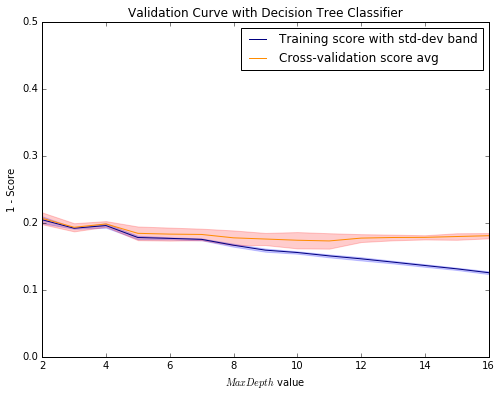

In [75]:
fig, ax = plt.subplots(figsize=(8, 6)) 
plt.title("Validation Curve with Decision Tree Classifier")
plt.xlabel("$Max Depth$ value".format())
plt.ylabel("1 - Score")
plt.ylim(0.0, 0.5)

lw = 1

plt.plot(param_range, train_scores_mean, label="Training score with std-dev band",
             color="navy", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="blue", lw=lw)

plt.plot(param_range, test_scores_mean, label="Cross-validation score avg",
             color="darkorange", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)

plt.legend(loc="best")


### now build decision tree 
and draw with graphviz

In [54]:
param_grid = {
        'max_leaf_nodes': [
                    15,
#                     10,
                    ], # number of final count of leaf nodes
    
            'class_weight': [
#                         None,
                        'balanced',
                        ], # with imbalanced taret classes
            'criterion': [
                        'gini',
                        ], # the split criterion   
            "max_depth": [ 
                        4,
                6,
                5,
                            ],# max tree depth            
              "max_features": [
                               None,
                                'auto',
#                                20,
#                                0.75,
                           ],# number of features to consider at each split
              }

In [55]:
# define loss function

scoring = 'f1'
# scoring = 'roc_auc'
# scoring = 'neg_log_loss'

In [63]:
%%time
start_time = time.time()

num_jobs = -1

dtree  = DecisionTreeClassifier( )
clf =GridSearchCV( dtree, 
                  param_grid, 
                  scoring=scoring, 
                  fit_params=None,
                  n_jobs=num_jobs,
                  cv=10,
                  iid=True, 
                  refit=True, 
                verbose=0, 
                pre_dispatch='2*n_jobs', 
                  error_score='ignore')

clf2 = DecisionTreeClassifier( )

clf.fit(X, Y)

elapsed_time =   time.time() - start_time 
print('HyperParam Search took %s seconds to run' % (elapsed_time))


cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, 
                            value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key,
                                        value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1

elapsed_time =   time.time() - start_time

clf2.set_params(**clf.best_params_)
clf2.fit(X,Y)

#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

HyperParam Search took 71.6644229888916 seconds to run
CPU times: user 24.6 s, sys: 587 ms, total: 25.2 s
Wall time: 1min 14s


In [64]:
finished

True

In [65]:
print('\n Best estimator was %s \n' % str(clf.best_estimator_))

print('\n Best estimator was {:.3f} in "{}" metric \n'.format( clf.best_score_,
                                                    scoring
                                                   )
     )


## get testing score with the score used inour function
scoring_fun = SCORERS[scoring]
test_score = scoring_fun(clf,X_val,Y_val)

print('\nBest estimator\'s performance with \
"{}" metric on the test set is: {:.3f}\n'.format( scoring,
                                                 test_score,  
                                            )
     )



print('Param exploration Search took %s seconds to run' % (elapsed_time))

print('Our problem type id is {} which means \"{}\"'.format(case,case_text.capitalize()))

#ojo que esta parte cuando poly ==True no funciona..


 Best estimator was DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=15, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 


 Best estimator was 0.578 in "f1" metric 


Best estimator's performance with "f1" metric on the test set is: 0.579

Param exploration Search took 71.68791484832764 seconds to run
Our problem type id is 2 which means "People that migrated in any direction"


## now draw tree

In [66]:
from sklearn import tree

In [67]:
DATADIR

'/Users/jampper/Repositories/Tesis/mexico-scripts-ver2/datasets'

In [62]:
file_tree = 'tree.dot'
outf = os.path.join(DATADIR,file_tree)

tree.export_graphviz(clf2,
                    max_depth = 4,
                        impurity = True,
                        proportion = True,
                     feature_names = X.columns,
                    out_file=outf)

# sub_call = 'dot -Tps {} -o {} '.format(file_tree, file_tree.replace('.dot','.ps'))
sub_call = 'dot -Tpng {} -o {} '.format(file_tree, file_tree.replace('.dot','.png'))
print(sub_call)

dot -Tpng tree.dot -o tree.png 


# Show the importance of cross validation and regularization using the logistic regression. 

try with different 

* cv values: (1, 3, 10 and 20)

* C regularization values (L2): (1/10, 1, 10000,20000 ,etc. - high values)


### define our X matrix

In [41]:
# make this algorithm nilpotent (copy the data from the original case's X)
# in case we want to run this again without re-building the whole X
X_lreg = X.copy()
X_val_lreg = X_val.copy()

In [40]:
# # define our c range to compare
# inv_c_range = pd.np.logspace(-4, 100, 15)

# # param_range = 1./inv_c_range
# param_range = pd.np.linspace(-3,0.5,30)
# # param_range = pd.np.ceil(param_range)
# param_range = pd.np.exp((param_range)*pd.np.log(10))

# low_values = pd.np.linspace(0.001,1,10) 
# high_values = pd.np.linspace(10000,20000,10)
# param_range = pd.np.concatenate([low_values,high_values])

param_range = pd.np.logspace(-5, 2, 100)
param_range[:20],param_range[-20:]

(array([  1.00000000e-05,   1.17681195e-05,   1.38488637e-05,
          1.62975083e-05,   1.91791026e-05,   2.25701972e-05,
          2.65608778e-05,   3.12571585e-05,   3.67837977e-05,
          4.32876128e-05,   5.09413801e-05,   5.99484250e-05,
          7.05480231e-05,   8.30217568e-05,   9.77009957e-05,
          1.14975700e-04,   1.35304777e-04,   1.59228279e-04,
          1.87381742e-04,   2.20513074e-04]),
 array([   4.53487851,    5.33669923,    6.28029144,    7.39072203,
           8.69749003,   10.23531022,   12.0450354 ,   14.17474163,
          16.68100537,   19.6304065 ,   23.101297  ,   27.18588243,
          31.99267138,   37.64935807,   44.30621458,   52.14008288,
          61.35907273,   72.20809018,   84.97534359,  100.        ]))

## Fit with no cv, high and low regularization comparison

### check if we want SVD

In [43]:
%%time

svd_features = False
num_features_limit = 30

#note that some svd algorithms are non-deterministic and thus results will vary if random state is not specified
svd = TruncatedSVD(
    n_components=num_features_limit, 
    n_iter=100, 
    random_state=42 ,
    
                )
if svd_features: # only for train and test
    svd.fit(X_lreg) 
    X_lreg = pd.DataFrame(svd.transform(X_lreg), index = X_lreg.index.values)
    X_val_lreg = pd.DataFrame(svd.transform(X_val_lreg), index = X_val_lreg.index.values)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs


In [44]:
X_lreg.shape, X.shape

((137831, 152), (137831, 152))

In [46]:
# define loss function

scoring = 'f1'
# scoring = 'accuracy'
# scoring = 'precision'
# scoring = 'recall'
# scoring = 'roc_auc'
# scoring = 'neg_log_loss'

## NO CV
LOGREG

In [52]:
%%time

start_time = time.time()

num_jobs = -1

logreg  =  LogisticRegression(solver = 'lbfgs', 
                       max_iter = 250,
                      warm_start=False,
                              verbose = 0,
                              n_jobs =-1,
                        )
# init fit over a range of parameters and load these into the
# test and train scoring lists
scores = []
scores_val = []

## get testing score fun with our defined str score
scoring_fun = SCORERS[scoring]

for param in param_range:

    logreg.set_params(C=param)
    logreg.fit(X_lreg, Y)
    
    # get train and "test" errors without CV
    error = scoring_fun(logreg,X_lreg,Y)

    scores.append(error)
    error_val = scoring_fun(logreg,
                            X_val_lreg,
                            Y_val)
    scores_val.append(error_val)

# cast to numpy arrays type
scores = pd.np.asarray(scores)
scores_val = pd.np.asarray(scores_val)

elapsed_time =   time.time() - start_time 
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

CPU times: user 1min 16s, sys: 3min 55s, total: 5min 12s
Wall time: 14min 32s


In [53]:
finished

True

In [56]:
print('Param exploration Search took %s seconds to run' % (elapsed_time))

max_score_index = pd.np.nonzero(scores == scores.max())[0][0]

max_val_score_index = pd.np.nonzero(scores_val == scores_val.max())[0][0]

print('\n Best estimator had ({:.3f},{:.3f}) error and error_val score\
with scoring metric {} \n'.format(
                                 scores[max_score_index] ,
                                 scores_val[max_val_score_index],
                                scoring,
                               )
    )

print('\n Best param found with this metric was {} \n'.format( str( (param_range[max_score_index],
                                           param_range[max_val_score_index])
                                           )
                                      )
     )

print('Our problem type id is {} which means \"{}\"'.format(case,case_text.capitalize()))

Param exploration Search took 872.792695045 seconds to run

 Best estimator had (-0.547,-0.535) error and error_val scorewith scoring metric neg_log_loss 


 Best param found with this metric was (1.0000000000000001e-05, 0.0048873746316244271) 

Our problem type id is 0 which means "People that used to live in the endemic area"


In [61]:
# get elapsed time in hours
elapsed_time/3600, finished

(0.24244241529040866, True)

In [64]:
# reverse_scores_train = 1 - train_scores
# reverse_scores_test = 1 - test_scores

train_scores_mean = scores
train_scores_std = pd.np.std(scores)
test_scores_mean = scores_val
test_scores_std = pd.np.std(scores_val)

In [65]:
pd.np.std(scores), param_range.shape, train_scores_mean.shape, test_scores_mean.shape, train_scores_std.shape

(6.8053344896406231e-08, (120,), (120,), (120,), ())

In [72]:
train_scores_mean.max(), train_scores_mean.min()

(-0.54674996288044209, -0.54675060857410918)

In [66]:
size = param_range.shape[0]
#i = 0.002
#pd.np.linspace(1+i,1,size)
size

120

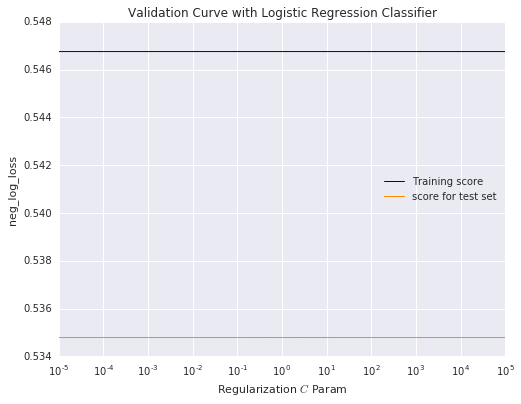

In [70]:
ax, fig = plt.subplots(figsize=(8,6))
plt.title("Validation Curve with Logistic Regression Classifier")
plt.xlabel("Regularization $C$ Param")
plt.ylabel("{}".format(scoring))
# plt.ylim(0.0, 10.1)

lw = 1

plt.semilogx(param_range, -train_scores_mean,#
                          label="Training score",
             color="navy", lw=lw)

# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="blue", lw=lw)

plt.semilogx(param_range, -test_scores_mean,#
             label="score for test set",
             color="darkorange", lw=lw)

# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="red", lw=lw)

plt.legend(loc="best")


In [173]:
a =0.51
b= 0.506
(a-b)/a


0.007843137254901968

## now add manual cross validation to the problem

show different instances of l1 and l2 regularization (low C) vs. non-regularizing (high C)

yes manual cv

logreg

In [51]:
min_val = -4.5; max_val = 1.3 ; n_points = 70
param_range = pd.np.logspace(min_val,max_val,n_points)

In [52]:
param_range

array([  3.16227766e-05,   3.83758467e-05,   4.65710406e-05,
         5.65163249e-05,   6.85854329e-05,   8.32319089e-05,
         1.01006152e-04,   1.22576099e-04,   1.48752327e-04,
         1.80518510e-04,   2.19068387e-04,   2.65850622e-04,
         3.22623243e-04,   3.91519704e-04,   4.75129061e-04,
         5.76593265e-04,   6.99725234e-04,   8.49152138e-04,
         1.03048928e-03,   1.25055112e-03,   1.51760735e-03,
         1.84169365e-03,   2.23498886e-03,   2.71227258e-03,
         3.29148064e-03,   3.99437905e-03,   4.84738201e-03,
         5.88254445e-03,   7.13876669e-03,   8.66325623e-03,
         1.05133018e-02,   1.27584261e-02,   1.54829985e-02,
         1.87894057e-02,   2.28018988e-02,   2.76712632e-02,
         3.35804844e-02,   4.07516247e-02,   4.94541679e-02,
         6.00151464e-02,   7.28314306e-02,   8.83846429e-02,
         1.07259257e-01,   1.30164560e-01,   1.57961309e-01,
         1.91694078e-01,   2.32630507e-01,   2.82308944e-01,
         3.42596253e-01,

In [56]:
# define thos hyper params of the model which will be fixed
fixed_params = {
        'penalty': [
                    'l1',
#                     'l2',
        ], # type of regularization function norm
            'max_iter': [
#                         40,
                        100,
#                         200,
                        ], # number of descent iterations
    
            "fit_intercept": [ 
#                         False, 
                        True,
                            ],# fit the constante intercept
            
               "class_weight": [
#                                None,
                            'balanced',
                           ],# if class ratios are as weighted averge when computing the overall loss fn
              }

# given that we have one valued lists,
# convert all values to scalars and not lists
fixed_params = {key:value[0] for key, value in fixed_params.items()}

In [55]:
fixed_params

{'class_weight': 'balanced',
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1'}

In [57]:
# define those hyperparams of the model which we will be changing/iterating
dynamic_params = {'C': param_range}# the regularization param, the smaller the more regularized

In [59]:
# define loss function of interest

scoring = 'f1'
# scoring = 'accuracy'
# scoring = 'precision'
# scoring = 'recall'
# scoring = 'roc_auc'
# scoring = 'neg_log_loss'

# manually CV
over a range of param values for one single hyperparam argument

In [ ]:
%%time

start_time = time.time()

num_jobs = -1

logreg  = LogisticRegression(**fixed_params)
scoring_fun = SCORERS[scoring]

scores_test = []
cv_scores_mean = []
cv_scores_std = []

key = 'C'

for val in param_range:
    # first init a logistic Regression model with param set
    kw = {key:val}
    logreg.set_params(**kw)
    # get CV error first, doing N folds on the training set
    cv_scores = cross_val_score(logreg,
                                X_lreg,
                                Y,
                                cv = 8,
                                n_jobs = num_jobs,
                                scoring = scoring_fun,
                                pre_dispatch = '4*n_jobs',)
    # get folds mean cv score and std score
    mean_cv_score, std_cv_score  = (cv_scores.mean(), cv_scores.std())
    cv_scores_mean.append(mean_cv_score)
    cv_scores_std.append(std_cv_score)    
    
    # now get test error by fitting the logReg model on the whole training set
    # and scoring on the testing set
    logreg.fit(X_lreg, Y)
    test_error = scoring_fun(logreg,
                             X_val_lreg,
                             Y_val)
    # save test score
    scores_test.append(test_error)


# capture the test error for each model
errors_df = {key : param_range,
             'test_error' : scores_test,
            'std_cv_error' : cv_scores_std,
             'mean_cv_error' : cv_scores_mean,
            }
errors_df = pd.DataFrame(errors_df)


elapsed_time =   time.time() - start_time 

In [126]:
max_val

2

In [130]:
# the key column values were extracted by transforming linear space to an exponent.
# thus to come back to the linear space we have to take the natural logarithm
#  and add it to the DF
log_key = 'log_{}'.format(key)
errors_df[log_key] = pd.np.linspace(min_val,max_val,n_points)


In [132]:
print('CV vs. Test Error Search took %s seconds to run' % (elapsed_time))

# este flag es basicamente para chequear que hayamos terminado nomas
# we also get elapsed time in hours
finished = True
finished, elapsed_time/3600

CV vs. Test Error Search took 8559.10971093 seconds to run


(True, 2.377530475258827)

In [107]:
max_test_error = errors_df['test_error'].max()
max_cv_error = errors_df['mean_cv_error'].max()

best_estim_test = errors_df.loc[errors_df['test_error'].argmax(),key]#.values[0]
best_estim_cv = errors_df.loc[errors_df['mean_cv_error'].argmax(),key]#.values[0]
# best_score = errors_df.loc[errors_df['test_error'].argmax(),key].values[0]

print('\n Best CV estimator was {}:{!s} \n'.format(key,best_estim_cv))
print('\n Best CV error was {:.3f} in "{!r}" metric \n'.format( max_cv_error,
                                                    scoring
                                                   )
     )

print('\n Best estimator for test set was {}:{!s} \n'.format(key, best_estim_test))
print('\n Best Test error was {:.3f} in "{!r}" metric \n'.format( max_test_error,
                                                    scoring
                                                   )
     )

print('Param exploration Search took %s seconds to run' % (elapsed_time))

print('Our problem type id is {} which means \"{}\"'.format(case,case_text.capitalize()))

#ojo que esta parte cuando poly ==True no funciona..


 Best CV estimator was C:1.10529514113 


 Best CV error was 0.756 in "'roc_auc'" metric 


 Best estimator for test set was C:2.01533768594 


 Best Test error was 0.783 in "'roc_auc'" metric 

Param exploration Search took 8559.10971093 seconds to run
Our problem type id is 2 which means "People that migrated in any direction"


In [110]:
errors_df.columns

Index([u'C', u'mean_cv_error', u'std_cv_error', u'test_error'], dtype='object')

In [137]:
error_cols = ['mean_cv_error', 'test_error' ]
rev_error_cols = []
for col in error_cols:
    rev_col = 'rev_'+col
    errors_df[rev_col] = 1- errors_df[col]
    rev_error_cols+=[rev_col]

In [138]:
rev_error_cols 

['rev_mean_cv_error', 'rev_test_error']

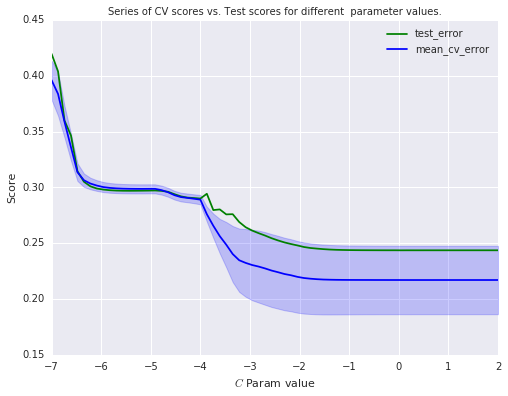

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))


x_col = log_key
labels = error_cols
# plot series
# view[an_col].hist()

colors = ['g','b']
smoother = 7
lw = 1
for i,col in enumerate(rev_error_cols):
    
    errors_df.plot(x = x_col, y = col,ax=ax, 
                   kind = 'line',color = colors[i],
                  label = error_cols[1-i])
    
    

plt.fill_between(errors_df[log_key], errors_df['rev_test_error'] - errors_df['std_cv_error']/smoother,
                 errors_df['rev_test_error'] + errors_df['std_cv_error']/smoother, alpha=0.2,
                 color=colors[1], lw=lw)

# sup_title_str = ""

# plt.suptitle("\n".join(wrap(sup_title_str)),
#          y=1.03,# otherwise twiny and title will overlap
#          fontsize=18,
#             )

title_str = "Series of CV scores vs. Test scores for different \
 parameter values."

plt.title(title_str, fontsize=10)

plt.xlabel("$C$ Param value")
plt.ylabel("Score".format(scoring.capitalize()))
# plt.ylabel("{} Score".format(scoring.capitalize()))


In [60]:
errors_df.head(20)

## full grid search CV 
over logreg and over multiple metrics

In [82]:

def fit_cv_procedure(clf_object,X,Y,
                     scoring, param_grid, num_jobs, 
                     **kw):
    rv = {}
    out_str = ""
    error_str = ""
    start_time = time.time()
    
    clf =GridSearchCV( clf_object, 
                      param_grid, 
                      scoring=scoring, 
                      n_jobs=num_jobs, 
                      **kw
                      )

    try:
        
        clf.fit(X, Y)
        
        grid_time =   time.time() - start_time 
    
        out_str+='HyperParam Search took {} seconds to run'.format(elapsed_time)

        cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, 
                                value in clf.grid_scores_[0].parameters.items() ] )

        for i, setup in enumerate(clf.grid_scores_):
            row = [clf.grid_scores_[i].mean_validation_score ] + [value for key,
                                                value in clf.grid_scores_[i].parameters.items() ]
            cv_result.loc[i] = row
        
        rv['cv_result'] = cv_result
        rv['grid_time'] = grid_time

    except Exception as e:
        error_str = str(e)
    
    #este flag es basicamente para chequear que hayamos terminado nomas
    rv['clf'] = clf
    rv['out_str'] = out_str
    rv['error_str'] = error_str
    
    return rv

In [83]:


param_grid = {
        'penalty': [
                    'l1',
#                     'l2',
        ], # type of regularization function norm
#             'C': param_range,
    'C': [1],
    # the regularization param, the smaller the more regulareized
            'max_iter': [
#                         40,
                        100,
#                         200,
                        ], # number of descent iterations
    
            "fit_intercept": [ 
#                         False, 
                        True,
                            ],# fit the constante intercept
            
               "class_weight": [
#                                None,
                            'balanced',
                           ],# if class ratios are as weighted averge when computing the overall loss fn
              }

#print cardinality of this grid search
cardinality  = 1
for key in param_grid.keys():
    cardinality = cardinality*len(param_grid[key])
print(cardinality)


1


In [84]:
param_grid

{'C': [1],
 'class_weight': ['balanced'],
 'fit_intercept': [True],
 'max_iter': [100],
 'penalty': ['l1']}

In [ ]:
%%time

# explicit named args
num_jobs = -1
logreg  = LogisticRegression( )

# implicit kwargs (less important arguments)
kwargs = {'refit':True,
         'fit_params':None,
         'iid':True,
          'verbose':0,
         'pre_dispatch':'4*n_jobs',
          'error_score':'ignore',
          'cv':8,
         }



scoring_list = [
'accuracy',
'precision',
'recall',
 'f1',
# 'roc_auc',
]

scoring_classifiers = {}
elapsed_time = 0

for scoring in scoring_list:
    
    res = fit_cv_procedure(logreg, 
                    X = X_lreg,
                    Y = Y,
                    scoring = scoring,
                    param_grid = param_grid,
                    num_jobs = num_jobs,
                    **kwargs)
    
    grid_time = res['grid_time']
    clf = res['clf']
    print(grid_time)
    
    score_str+='\n Best estimator was {!s} \n'.format(clf.best_estimator_)
    score_str+='\n Best estimator\'s score was {:.3f} in "{}" \n'.format( clf.best_score_,
                                                        scoring)

    ## get testing score with the score used inour function
    scoring_fun = SCORERS[scoring]
    test_score = scoring_fun(clf,X_val_lreg,Y_val)

    score_str+='\nBest estimator\'s performance with \
    "{}" metric on the test set is: {:.3f}\n'.format( scoring,
                                                     test_score,
                                                    )


    score_str+='\nParam exploration Search took %s seconds to run'.format(grid_time)

    score_str+='\nOur problem type id is {} which means \"{}\"'.format(case,case_text.capitalize())
    
    res['test_score'] = test_score
    res['score_str'] = score_str
    
    scoring_classifiers[scoring] = res
    elapsed_time += res['grid_time']

finished = True
    

In [ ]:
finished

In [ ]:
# get elapsed time in hours
elapsed_time/3600, finished

In [200]:
group_cols = [
        'penalty',
              'C',
]

an_col = 'mean_score'
param_col = 'C'
#.groupby(group_cols)['mean_score'].first()
filter_col = 'penalty'
filter_val = 'l1'
view = (cv_result
        .query('{}==@filter_val'.format(filter_col))
        [[ param_col,filter_col,an_col]]
        #.sort_values('mean_score',ascending=False)
       )

In [201]:
view[an_col].describe()

count    200.000000
mean       0.802970
std        0.001776
min        0.802210
25%        0.802213
50%        0.802226
75%        0.802275
max        0.809081
Name: mean_score, dtype: float64

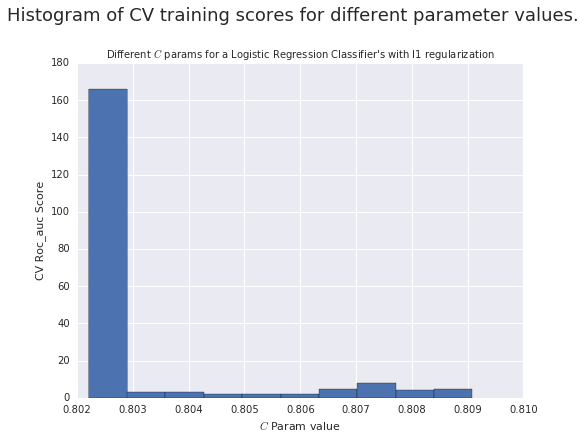

In [202]:
fig, ax = plt.subplots(figsize=(8, 6))
# plot histogram on cross validated scores
view[an_col].hist()

sup_title_str = "Histogram of CV training scores for different \
parameter values."

plt.suptitle("\n".join(wrap(sup_title_str)),
         y=1.03,# otherwise twiny and title will overlap
         fontsize=18,
            )

title_str = "Different $C$ params \
for a Logistic Regression Classifier\'s with \
{} regularization".format(
    filter_val)

plt.title(title_str, fontsize=10)

plt.xlabel("$C$ Param value".format(filter_val))
plt.ylabel("CV {} Score".format(scoring.capitalize()))




In [203]:
# view = view.sort_values(param_col)
# x_vals = view[param_col]
# y_vals = view[param_col]


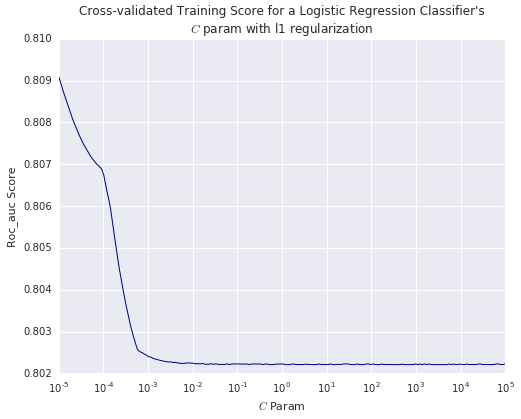

In [204]:
ax, fig = plt.subplots(figsize=(8,6))
# plt.title("Validation Curve with Logistic Regression Classifier")
# plt.xlabel("Regularization $C$ Param")
# plt.ylabel("AUC Score")
# plt.ylim(0.0, 10.1)

lw = 1

plt.semilogx(
    view[param_col], 
    view[an_col],#
                          label="Training score",
             color="navy", lw=lw)


title_str = "Cross-validated Training Score \
for a Logistic Regression Classifier\'s $C$ \
param with {} regularization".format(
    filter_val)

plt.title("\n".join(wrap(title_str)),
         y=1,# otherwise twiny and title will overlap
         )


plt.xlabel("$C$ Param".format(filter_val))
plt.ylabel("{} Score".format(scoring.capitalize()))


## other linspace plot with double axis


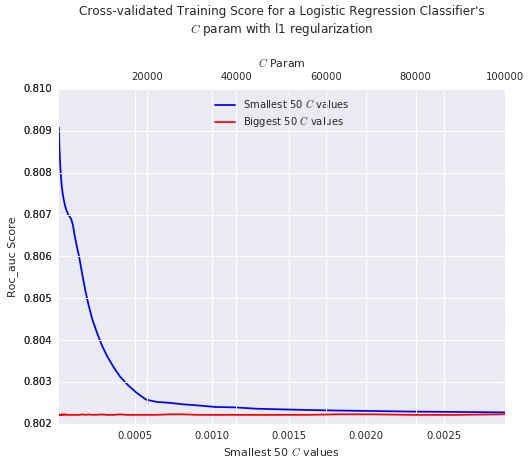

In [205]:
fig, ax = plt.subplots(figsize=(8, 6))

N=50

labels = ['Smallest {} $C$ values '.format(N), 'Biggest {} $C$ values '.format(N)]

c = palette[0]
view.head(N).set_index(param_col)[an_col].plot(
    ax=ax,
    kind = 'line',
    color='b',
#     legend=True,
    label =labels[0],
)

# set xlabel 
# ax.set_xlabel(labels[0])
# set series legend
# ax.legend(loc=0)

# get a new axis to plot on with new color
ax2 = ax.twiny()
c = palette[1]
view.tail(N).set_index(param_col)[an_col].plot(
    ax=ax2,
    kind = 'line',
    color='r',
#     legend=True,
    label =labels[1],
                                               
         )

ax.set_xlabel(labels[0])
ax2.set_xlabel(labels[1])

# get all plotted line objects
lines = ax.get_lines() + ax2.get_lines()
# set a common legend
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

# pass those lines legends

# # set series legend
# ax2.legend(loc='best')


title_str = "Cross-validated Training Score \
for a Logistic Regression Classifier\'s $C$ \
param with {} regularization".format(
    filter_val)

plt.title("\n".join(wrap(title_str)),
         y=1.15,# otherwise twiny and title will overlap
         )


plt.xlabel("$C$ Param".format(filter_val))
plt.ylabel("{} Score".format(scoring.capitalize()))




In [63]:
view.tail(30)

## now get erros along the cv procedure and plot

In [ ]:
# reverse_scores_train = 1 - train_scores
# reverse_scores_test = 1 - test_scores

train_scores_mean = errors
train_scores_std = pd.np.std(errors)
test_scores_mean = errors_val
test_scores_std = pd.np.std(errors_val)

In [ ]:
pd.np.std(errors), param_range.shape, train_scores_mean.shape, test_scores_mean.shape, train_scores_std.shape

In [ ]:
size = param_range.shape[0]
#i = 0.002
#pd.np.linspace(1+i,1,size)

In [ ]:
ax, fig = plt.subplots(figsize=(8,6))
plt.title("Validation Curve with Logistic Regression Classifier")
plt.xlabel("Regularization $C$ Param")
plt.ylabel("AUC Score")
# plt.ylim(0.0, 10.1)

lw = 1

plt.semilogx(param_range, train_scores_mean,#
                          label="Training score",
             color="navy", lw=lw)

# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="blue", lw=lw)

plt.semilogx(param_range, test_scores_mean,#
             label="score for test set",
             color="darkorange", lw=lw)

# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="red", lw=lw)

plt.legend(loc="best")

# REST of shit

old stuff - not necessary

## randomized cv 
instead of grid search 

In [ ]:

# # when cardinality of grid search is too big, we randomly search for
# n_iter_search = 100

# if n_iter_search < cardinality:
#     clf = RandomizedSearchCV(logreg, param_distributions=param_grid,
#                                  n_iter=n_iter_search, n_jobs = num_jobs, verbose=3,
#                                        iid=True, refit=True, )

# X = X
# Y = Y.values

### Count Featurizer on Antennas
nos quedamos con las columnas de antennas y en graphlab aplicamos el algo de CountFeaturizer para cada categoria de
Antenna_ID_N


In [ ]:
%%time
import graphlab as gl
from graphlab.toolkits.feature_engineering import *
ant_cols = [col for col in X_train.columns if "ANTENNA_ID" in col]
ant_sframe_fit = gl.SFrame(X_fit[ant_cols + ['y']])
ant_sframe_train = gl.SFrame(X_train[ant_cols + ['y']])
ant_sframe_val = gl.SFrame(X_val[ant_cols + ['y']])

In [ ]:
%%time
countfeat = gl.feature_engineering.create(ant_sframe_fit, 
               CountFeaturizer(target='y'))

# Transform the train set. This is the dataset I will train my classifier on
transformed_ant_train = countfeat.transform(ant_sframe_train)
transformed_ant_val = countfeat.transform(ant_sframe_val)

del ant_sframe_fit,ant_sframe_train,ant_sframe_val

#por alguna razon guarda los valores de probabilidad como una lista de un unico valor
for col in [col for col in transformed_ant_train.column_names() if "prob_" in col]:
    transformed_ant_train[col] = transformed_ant_train[col].apply(lambda x: x[0]) 
    transformed_ant_val[col] = transformed_ant_val[col].apply(lambda x: x[0]) 

#me quedo solo con los valores de probabilidad.
transformed_ant_train = transformed_ant_train[[col for col in transformed_ant_train.column_names() if "prob_" in col]]
transformed_ant_val = transformed_ant_val[[col for col in transformed_ant_train.column_names() if "prob_" in col]]

transformed_ant_val = transformed_ant_val.to_dataframe()
transformed_ant_train = transformed_ant_train.to_dataframe()

In [ ]:
X_val[ant_cols] = transformed_ant_val.values
X_train[ant_cols] = transformed_ant_train.values
del transformed_ant_train, transformed_ant_val

## Bernoulli RBM features selection & Logit crossval

In [127]:
start_time = time.time()

## obs. este metodo es especial y asume que todos los valores son True/False o que \in [0,1]
# luego tengo que pensar en como tomar los features nuevamente.
# tampoco 'fittea' en la forma tradicional. Sino que se le puede tomar al y como un feature mas y esta red
# va 'modificando' todos los valores del X (minimizando la entropia) para dar un output. Luego corriendo 
# clf.gibbs(X_test) con el y_test como feature tmb, nos transforma la data para ver el output como la 'prediccion'
# obviamente no tiene probabilidades


#X = X_train[X_cols].values
#y = X_train['ground_truth'].values

df = X_train.drop(X_train[X_train[X_train.columns[0:3]].\
                                   sum(axis=1)==0].index)
df = df[X_cols + ['ground_truth']]

for col in X_train.columns[0:3]:
    df[col] = df[col]*1.0/df[df.columns[0:3]].sum(axis=1)

df[df.columns[3]] =  df[df.columns[3]]/df[df.columns[3]].max()
df[df.columns[4]] =  df[df.columns[4]]/df[df.columns[4]].max()

X = df[df.columns[:-1]].values
y = df['ground_truth'].values


param_grid = {'rbm__n_components': [256, 128,46,10],
   'rbm__n_iter':[15,10,5], 'rbm__learning_rate': [1e-4,1e-3,1e-2,1e-1,5*1e-3,5*1e-2,5*1e-1],
  'rbm__batch_size': [10e4,3*10e3, 1e3, 300],"logistic__C": [1.0, 10.0, 100.0] 
 }

rbm = BernoulliRBM(verbose=True)
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

clf =GridSearchCV(classifier, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

#este metodo NO tiene predicted proba, lo que hacemos es recorrer 
#predicted_labels = rbm.gibbs(X_test)[:,-1]
#real_labels = X_test[:,-1]
#print(classification_report(real_labels,predicted_labels ))


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))
all_time =   time.time() - start_time

finished = True

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
    
print('This cell took %s seconds to run' % all_time)


KeyboardInterrupt: 

In [ ]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

In [23]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


criterion
gini    0.802919
Name: mean_score, dtype: float64
criterion
gini    0.000598
Name: mean_score, dtype: float64


In [ ]:
%%time
#con decomposicion qr tratamos de ver si existe alguna columna que sea comb linear de las demas
linear_test = pd.np.linalg.qr(X_train.sample(1e6))[1]
#notar que devuelve la tabla de tamanyo N`columnas x Ncolumnas

#sumo a traves de las columnas para que me de el valor absoluto sumado de c/fila
linear_test = abs(linear_test.sum(axis=1))<1e-2
#si hubiese alguan que sea linearcomb entonces tendria que aparecer que toda la fila es de ceros
for i, col in enumerate(X_train.columns):
    if linear_test[i] == True:
        print(col)

# Todo

* xgboost
* libffm
